## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import add_tech
from message_ix.tools.add_dac import get_report

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


**Look up storage upperbound from scenario output**

In [2]:
storbase = message_ix.Scenario(mp, model=f'SSP_dev_SSP5_v0.1_dac', scenario="1000f_v0.13_dac-co2split_mpen5")


In [3]:
nodes = [node for node in storbase.set("node")]
len_periods = [5,5,5,5,5,5,5,5,10,10,10,10,10]

# Annual CO2 stored
co2_stored = storbase.var("EMISS",
    {"emission":"CO2_storage",
    "node":[node for node in nodes if node not in ["World","R12_GLB"]],
    "type_tec":"all"}).set_index(["node","year"])["lvl"].unstack().mul(len_periods,axis=1)

# Calculate storage volume requirements and constraint's value
co2stor_req = co2_stored.cumsum(axis=1)[[2110]].rename(columns={2110:"StorV"}) # storage volume
co2stor_con = np.round(co2stor_req.div(90).rename(columns={"StorV":"bound_emission"}),0) # values in cumulative bound_emission
co2stor_con

year,bound_emission
node,
R12_AFR,1506.0
R12_CHN,695.0
R12_EEU,139.0
R12_FSU,827.0
R12_LAM,934.0
R12_MEA,906.0
R12_NAM,1033.0
R12_PAO,439.0
R12_PAS,499.0


## Varying `SSP` and CO2 storage volume

In [4]:
ssps = ["SSP1","SSP2","SSP3","SSP4","SSP5"]
scens = {
    "stor1": 0.2,
    "stor2": 0.4,
    "stor3": 0.6,
    "stor4": 0.8,
    "stor5": 1.0,
        }

stor scenario: SSP1 stor1


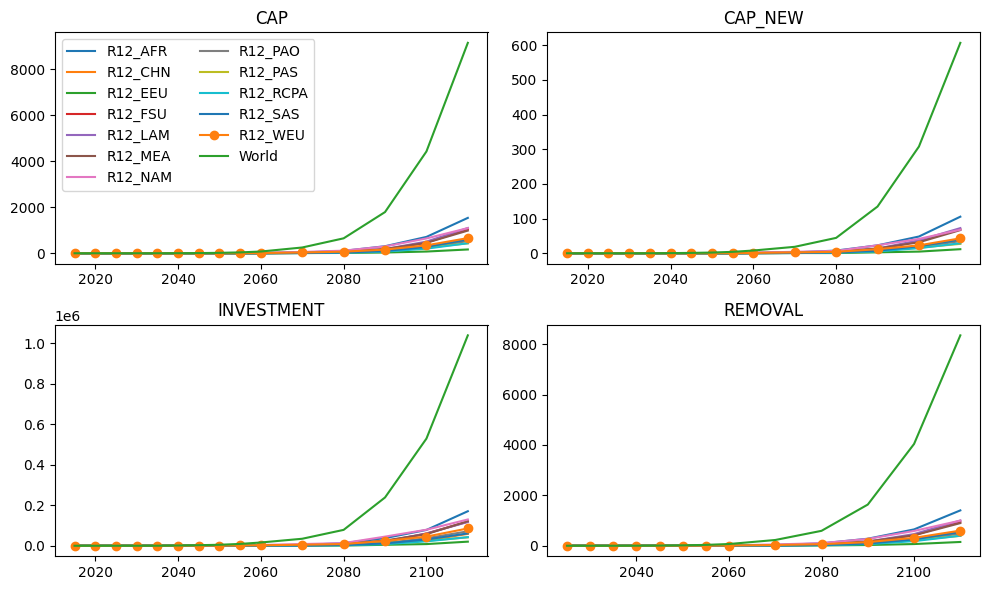

stor scenario: SSP1 stor2


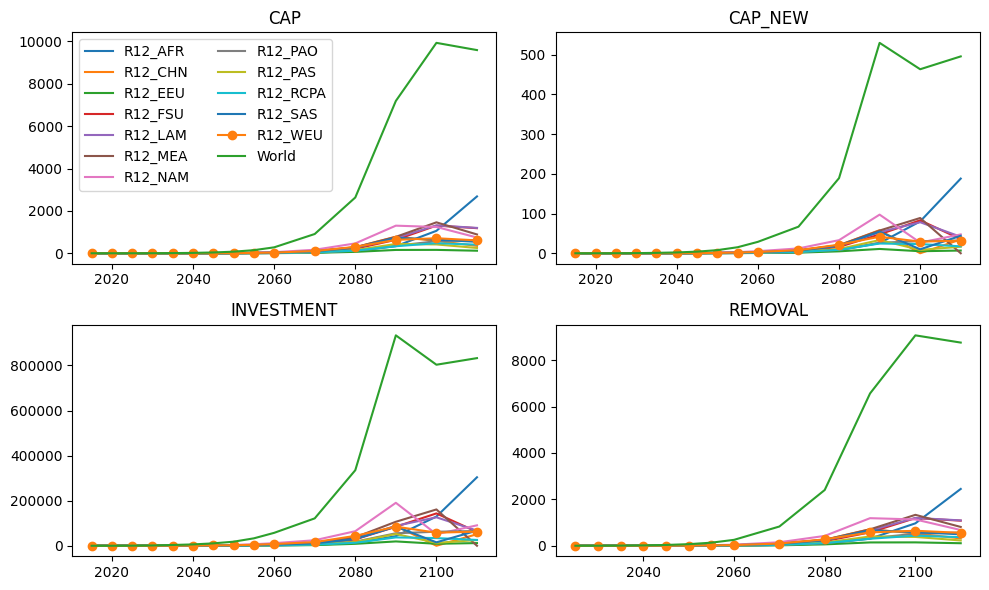

stor scenario: SSP1 stor3


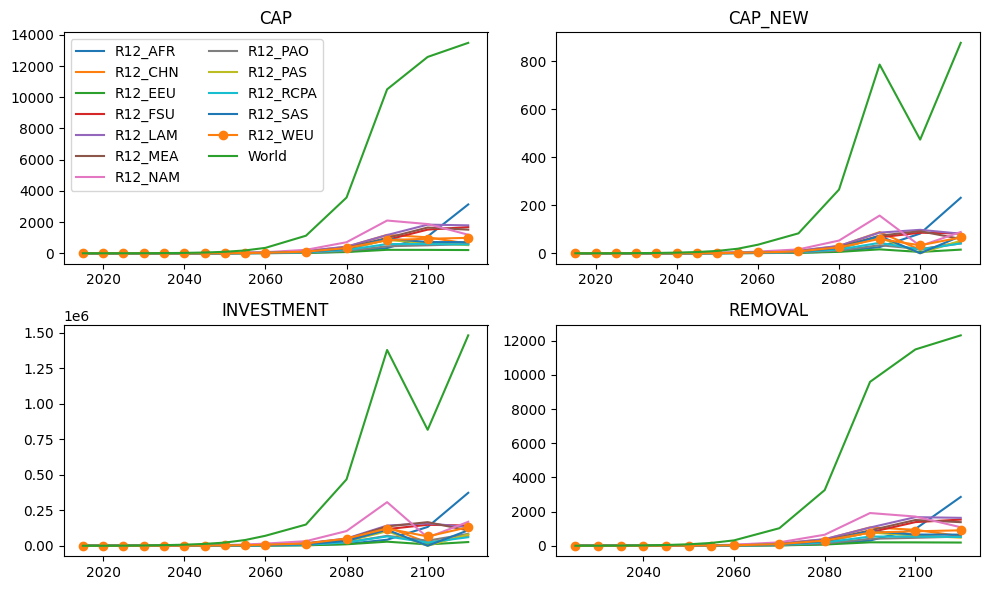

In [ ]:
# this is to import scenario from data base and clone to local
for ssp in ssps:
    for key,val in scens.items():
        dacsspscen = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1_dac', scenario="1000f_v0.13_dac-co2split")
        dacstor_scen = dacsspscen.clone(
            f"SSP_dev_{ssp}_v0.1_dac",
            f"1000f_v0.13_dac-co2split_mpen3_{key}",
            f"{ssp}_dev 1000f carbon budget with mpen3 dac, {key} storage, and split CO2 transmission and disposal",
            keep_solution=False, 
        )
        dacstor_scen.check_out()
        
        # adding set up for limiting storage volume
        if "CO2_storage" not in dacstor_scen.set("emission"):
            dacstor_scen.add_set("emission", "CO2_storage")
        if "co2_stor_pot" not in dacstor_scen.set("type_emission"):
            dacstor_scen.add_set("type_emission", "co2_storage_pot")
        if "co2_potential" not in dacstor_scen.set("type_tec"):
            dacstor_scen.add_set("type_tec", "co2_potential")
        if "co2_stor" not in dacstor_scen.set("technology"):
            dacstor_scen.add_set("technology", "co2_stor")

        dacstor_scen.add_set("cat_emission", ["co2_storage_pot", "CO2_storage"])
        dacstor_scen.add_set("cat_tec", ["co2_potential", "co2_stor"])
        
        # Updating storage volume limits
        nodes = [node for node in nodes if node not in ["R12_GLB","World"]]
        df_list = []
        for node in nodes:
            df = make_df("bound_emission",
                         node=node,
                         type_emission="co2_storage_pot",
                         type_tec="co2_potential",
                         type_year="cumulative",
                         value = co2stor_con.loc[node,"bound_emission"],
                         unit = "???",
                        )
            df_list = df_list + [df]
        df_stor = pd.concat(df_list)
        df_stor["value"] = df_stor["value"].mul(val) # ultimate potential x fraction
        
        dacstor_scen.add_par("bound_emission", df_stor)

        # add emission bound
        dacstor_scen.commit(comment=f"{ssp}_dev 1000f with DAC {key} scenario")
        dacstor_scen.set_as_default()

        dacstor_scen.solve(solve_options={'scaind': '1'})
        dacstor_scen.var("OBJ")["lvl"]

        # Get Report
        print("stor scenario:", ssp, key)
        if ssp == "SSP1":
            scenariotec = ['dac_lt','dac_ht']
            scenario_report = get_report(dacstor_scen,scenariotec)

## Close connection

In [ ]:
mp.close_db()